# Self-Supervised Pipeline for MCRT Denoising (Noise2Noise)

In [1]:
!pip install numpy torch tifffile imagecodecs

In [2]:
!nvidia-smi

Sat Jul  5 15:24:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# DATASET
import os
import torch
import random
import tifffile
import numpy as np
from torch.utils.data import Dataset

In [9]:
%%writefile histogram_dataset.py
import os
import torch
import random
import tifffile
import numpy as np
from torch.utils.data import Dataset

class HistogramDenoisingDataset(Dataset):
    def __init__(
        self,
        root_dir,
        crop_size=128,
        stride=None,
        mode='train',
        binomial_split=False,
        apply_augmentations=True
    ):
        self.root_dir = root_dir
        self.mode = mode
        self.crop_size = crop_size
        self.stride = stride if stride is not None else crop_size
        self.binomial_split = binomial_split
        self.apply_augmentations = apply_augmentations and mode == 'train'

        self.scene_dir = os.path.join(root_dir, mode)
        self.scene_names = sorted(os.listdir(self.scene_dir))  # subfolders per scene

        self.samples = []  # list of (scene_name, x, y)

        for scene in self.scene_names:
            scene_path = os.path.join(self.scene_dir, scene)
            npz_files = [f for f in os.listdir(scene_path) if f.endswith('.npz')]
            assert len(npz_files) == 1, f"Expected 1 .npz file in {scene_path}, found {len(npz_files)}"
            npz_path = os.path.join(scene_path, npz_files[0])

            with np.load(npz_path) as data:
                hist = data[list(data.keys())[0]]  # assumes only one entry or the first is used

            H, W = hist.shape[:2]
            for y in range(0, H - crop_size + 1, self.stride):
                for x in range(0, W - crop_size + 1, self.stride):
                    self.samples.append((scene, x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        scene, x, y = self.samples[idx]
        scene_path = os.path.join(self.scene_dir, scene)

        # Load histogram
        npz_files = [f for f in os.listdir(scene_path) if f.endswith('.npz')]
        npz_path = os.path.join(scene_path, npz_files[0])
        with np.load(npz_path) as data:
            hist = data[list(data.keys())[0]]  # shape: (H, W, 3, B)

        # Load noisy TIFF (spp=32)
        noisy_files = [f for f in os.listdir(scene_path) if f.endswith('spp32.tiff')]
        assert len(noisy_files) == 1, f"Expected 1 spp32 file in {scene_path}, found {len(noisy_files)}"
        noisy = tifffile.imread(os.path.join(scene_path, noisy_files[0]))  # (H, W, 3)

        # Load clean TIFF (spp=1500) only for test
        clean = None
        if self.mode == 'test':
            clean_files = [f for f in os.listdir(scene_path) if f.endswith('spp1500.tiff')]
            assert len(clean_files) == 1, f"Expected 1 spp1500 file in {scene_path}, found {len(clean_files)}"
            # use memmap instead of imread to save RAM
            clean = tifffile.imread(os.path.join(scene_path, clean_files[0]))

        # Crop selection
        hist_crop = hist[y:y + self.crop_size, x:x + self.crop_size]
        noisy_crop = noisy[y:y + self.crop_size, x:x + self.crop_size]
        clean_crop = clean[y:y + self.crop_size, x:x + self.crop_size] if clean is not None else None

        # Binomial histogram split (optional)
        if self.binomial_split:
            h1 = np.random.binomial(hist_crop.astype(np.int32), 0.5)
            h2 = hist_crop.astype(np.int32) - h1
            hist_crop = (h1, h2)

        # Data augmentation (optional)
        if self.apply_augmentations:
            hist_crop, noisy_crop, clean_crop = self.apply_d4_augmentations(hist_crop, noisy_crop, clean_crop)

        # Convert to torch tensors
        if self.binomial_split:
            h1_tensor = torch.tensor(hist_crop[0], dtype=torch.float32).permute(2, 3, 0, 1)  # (3, B, H, W)
            h2_tensor = torch.tensor(hist_crop[1], dtype=torch.float32).permute(2, 3, 0, 1)
            hist_tensor = (h1_tensor, h2_tensor)
        else:
            hist_tensor = torch.tensor(hist_crop, dtype=torch.float32).permute(2, 3, 0, 1)  # (3, B, H, W)

        noisy_tensor = torch.tensor(noisy_crop, dtype=torch.float32).permute(2, 0, 1)
        clean_tensor = torch.tensor(clean_crop, dtype=torch.float32).permute(2, 0, 1) if clean_crop is not None else None

        sample = {
            'histogram': hist_tensor,
            'noisy': noisy_tensor,
            'scene': scene
        }

        if clean_tensor is not None:
            sample['clean'] = clean_tensor

        return sample

    def apply_d4_augmentations(self, hist, noisy, clean):
        aug_id = random.randint(0, 7)

        def transform(img):
            if aug_id >= 4:
                img = np.rot90(img, k=aug_id - 4, axes=(0, 1))
            if aug_id % 4 == 1:
                img = np.flip(img, axis=0)
            elif aug_id % 4 == 2:
                img = np.flip(img, axis=1)
            elif aug_id % 4 == 3:
                img = np.flip(img, axis=(0, 1))
            return img.copy()

        if self.binomial_split:
            h1, h2 = hist
            return (transform(h1), transform(h2)), transform(noisy), transform(clean) if clean is not None else None
        else:
            return transform(hist), transform(noisy), transform(clean) if clean is not None else None

Overwriting histogram_dataset.py


In [10]:
# MODEL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from histogram_dataset import HistogramDenoisingDataset

# PLOTS
import matplotlib.pyplot as plt

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configurations

In [24]:
maxepochs = 10
batch_size = 4
crop_size = 128
stride = 128  # or 128 if you want no overlap
num_workers = 2

ROOT_DIR = '/content/drive/MyDrive/mcrt-data/files'  # update with your dataset root

## Prepare Dataset

**HistogramBinomDataset**: performs binomial splitting based of coefficient _p_

Input: **(N, H, W, B)** where:
- N = number of sample images
- H x W = dimension of the image
- B = number of bins



In [25]:
# Create dataset instances
train_dataset = HistogramDenoisingDataset(
    root_dir=ROOT_DIR,
    crop_size=crop_size,
    stride=stride,
    mode='train',
    binomial_split=True,
    apply_augmentations=True
)

test_dataset = HistogramDenoisingDataset(
    root_dir=ROOT_DIR,
    crop_size=crop_size,
    stride=crop_size,  # no overlap during validation
    mode='test',
    binomial_split=False,  # no binomial split for validation
    apply_augmentations=False
)

In [26]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    pin_memory=True,
    num_workers=num_workers
)

In [27]:
img = next(iter(test_loader))
print("Batch shape:", img['histogram'].shape)
print("Noisy shape:", img['noisy'].shape)
print("Clean shape:", img['clean'].shape)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Batch shape: torch.Size([4, 3, 17, 128, 128])
Noisy shape: torch.Size([4, 3, 128, 128])
Clean shape: torch.Size([4, 3, 128, 128])
Train dataset size: 384
Test dataset size: 96


## U-NET
- **Forward**:
  - Sinusoidal Encoding + Encoder + Decoder
- **Loss Function**:
  - KL-Divergence
  - Mean Squared Error
- **Output**:
  - Clean Histogram
  - Average Value

In [28]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, n_bins=33, out_mode='mean'):
        """
        Args:
            in_channels: input channels (usually 3 for RGB)
            n_bins: number of histogram bins
            out_mode: 'mean' for RGB output, 'distribution' for histogram prediction
        """
        super(UNet, self).__init__()
        self.out_mode = out_mode
        self.n_bins = n_bins

        # Input is (3, B, H, W), reshape to (3*B, H, W)
        self.input_channels = in_channels * n_bins

        # Encoder
        self.enc1 = self.conv_block(self.input_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.dec4 = self.up_block(1024, 512)
        self.dec3 = self.up_block(512, 256)
        self.dec2 = self.up_block(256, 128)
        self.dec1 = self.up_block(128, 64)

        # Output layer
        if self.out_mode == 'mean':
            self.final = nn.Conv2d(64, 3, kernel_size=1)
        elif self.out_mode == 'distribution':
            self.final = nn.Conv2d(64, 3 * n_bins, kernel_size=1)
        else:
            raise ValueError("Invalid out_mode. Use 'mean' or 'distribution'.")

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            self.conv_block(out_c, out_c)
        )

    def forward(self, x):
        # Reshape histogram input: (B, 3, bins, H, W) → (B, 3*bins, H, W)
        B, C, bins, H, W = x.shape
        x = x.view(B, C * bins, H, W)

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder
        d4 = self.dec4(b)
        d4 = d4 + e4  # skip connection

        d3 = self.dec3(d4)
        d3 = d3 + e3

        d2 = self.dec2(d3)
        d2 = d2 + e2

        d1 = self.dec1(d2)
        d1 = d1 + e1

        out = self.final(d1)

        if self.out_mode == 'distribution':
            # reshape to (B, 3, bins, H, W)
            out = out.view(B, 3, self.n_bins, H, W)
            out = F.softmax(out, dim=2)  # softmax over bins

        return out

# Training

In [51]:
def compute_mean_from_histogram(hist, bin_centers=None):
    """
    hist: Tensor of shape (B, 3, bins, H, W) or (3, bins, H, W)
    bin_centers: Optional tensor of bin centers (default: range(bins))
    """
    if hist.dim() == 4:
        # Add batch dimension if missing
        hist = hist.unsqueeze(0)  # shape: (1, 3, bins, H, W)

    B, C, bins, H, W = hist.shape

    if bin_centers is None:
        bin_centers = torch.arange(bins, device=hist.device).float()  # (bins,)

    # Reshape for broadcasting: (1, 1, bins, 1, 1)
    bin_centers = bin_centers.view(1, 1, bins, 1, 1)

    # Normalize histogram (prevent division by zero)
    hist_sum = hist.sum(dim=2, keepdim=True) + 1e-8
    hist_normalized = hist / hist_sum

    # Weighted sum to compute mean
    mean = (hist_normalized * bin_centers).sum(dim=2)  # shape: (B, 3, H, W)

    return mean

In [20]:
def train_epoch(model, loader, optimizer, criterion, device=device):
    model.train()
    total_loss = 0

    for batch in loader:
        hist = batch['histogram']  # tuple (h1, h2)

        # Use h1 as input, h2 as target
        input_hist = hist[0].to(device)
        target_hist = hist[1].to(device)

        optimizer.zero_grad()

        output_mean = model(input_hist)                # output shape: (B, 3, H, W)
        target_mean = compute_mean_from_histogram(target_hist)  # shape: (B, 3, H, W)

        loss = criterion(output_mean, target_mean)    # criterion = nn.MSELoss()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [21]:
model = UNet(in_channels=3, n_bins=17, out_mode='mean').to(device)

# Optimizer & loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [30]:
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}")

Epoch 1/10 - Train Loss: 2.1288
Epoch 2/10 - Train Loss: 1.1269
Epoch 3/10 - Train Loss: 0.9389
Epoch 4/10 - Train Loss: 0.8147
Epoch 5/10 - Train Loss: 0.7367
Epoch 6/10 - Train Loss: 0.6669
Epoch 7/10 - Train Loss: 0.6124
Epoch 8/10 - Train Loss: 0.5670
Epoch 9/10 - Train Loss: 0.5455
Epoch 10/10 - Train Loss: 0.5194


In [31]:
torch.save(model.state_dict(), "/content/drive/MyDrive//mcrt-data/hist2mean.pth")
print("Saved best model ! <3 :)")

Saved best model.


## Evaluation

In [62]:
def normalize_img(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min + 1e-8)

In [73]:
import torch
import math

def psnr(img1, img2, max_val=1.0):
    """
    Compute PSNR between two images (assumed to be tensors with shape [C,H,W] or [H,W,C]),
    where pixel values are in range [0, max_val].
    """
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * math.log10(max_val ** 2 / mse.item())

In [82]:
def test_and_plot(model, test_loader, device=device, num_samples=3):
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples:
                break

            hist = batch['histogram']
            clean_img = batch['clean']
            noisy_img = batch['noisy']

            input_hist = hist[0].to(device)
            target_hist = hist[1].to(device)

            print("Input Shape: ", input_hist.shape)

            # Forward pass (add batch dim)
            pred_mean = model(input_hist.unsqueeze(0))
            print("Pred Mean Shape: ", pred_mean.shape)

            pred_mean_img = pred_mean.squeeze(0).cpu()

            init_hist = compute_mean_from_histogram(hist[0].cpu())
            print("Init Hist Shape: ", init_hist.shape)

            # Compute PSNR
            clean_img_cpu = clean_img[0].cpu()
            noisy_img_cpu = noisy_img[0].cpu()

            # Compute PSNR assuming 8-bit images in [0,255]
            psnr_noisy = psnr(clean_img_cpu, noisy_img_cpu, max_val=255.0)
            psnr_pred = psnr(clean_img_cpu, pred_mean_img, max_val=255.0)
            psnr_init = psnr(clean_img_cpu, init_hist, max_val=255.0)

            print(f"Sample {i} PSNR (Clean vs Noisy): {psnr_noisy:.2f} dB")
            print(f"Sample {i} PSNR (Clean vs Init): {psnr_init:.2f} dB")
            print(f"Sample {i} PSNR (Clean vs Predicted): {psnr_pred:.2f} dB")

            # Plot
            fig, axs = plt.subplots(1, 4, figsize=(12, 4))

            # For noisy image
            noisy_img_np = noisy_img[0].cpu().numpy().transpose(1, 2, 0)  # (3,128,128) -> (128,128,3)
            axs[0].imshow(normalize_img(noisy_img_np))
            axs[0].set_title('Noisy Image')
            axs[0].axis('off')

            # For clean image
            init_hist_np = init_hist[0].cpu().numpy().transpose(1, 2, 0)
            axs[1].imshow(normalize_img(init_hist_np))
            axs[1].set_title('Initial Histogram')
            axs[1].axis('off')

           # For predicted mean (already single image, but normalize)
            pred_mean_np = pred_mean.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            axs[2].imshow(normalize_img(pred_mean_np))
            axs[2].set_title('Predicted Mean')
            axs[2].axis('off')

            # For clean image
            clean_img_np = clean_img[0].cpu().numpy().transpose(1, 2, 0)
            axs[3].imshow(normalize_img(clean_img_np))
            axs[3].set_title('Clean Image')
            axs[3].axis('off')

            plt.show()

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 0 PSNR (Clean vs Noisy): 77.74 dB
Sample 0 PSNR (Clean vs Init): 46.69 dB
Sample 0 PSNR (Clean vs Predicted): 41.68 dB


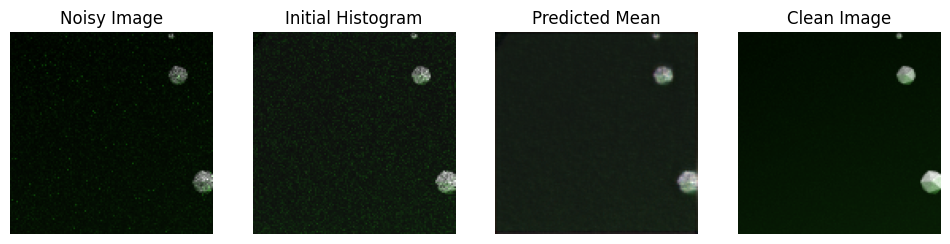

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 1 PSNR (Clean vs Noisy): 78.85 dB
Sample 1 PSNR (Clean vs Init): 45.80 dB
Sample 1 PSNR (Clean vs Predicted): 40.43 dB


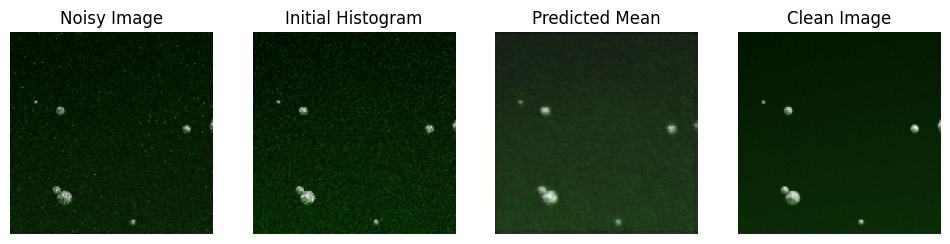

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 2 PSNR (Clean vs Noisy): 76.32 dB
Sample 2 PSNR (Clean vs Init): 43.09 dB
Sample 2 PSNR (Clean vs Predicted): 37.56 dB


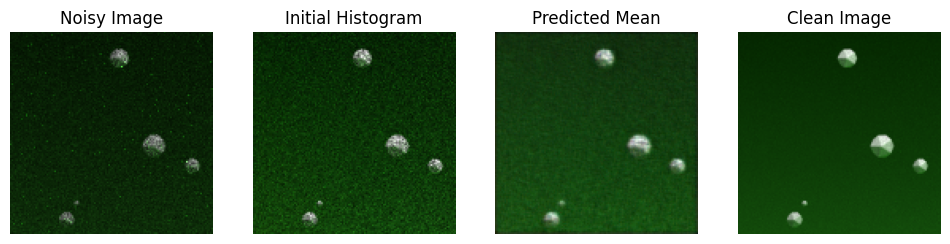

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 3 PSNR (Clean vs Noisy): 67.40 dB
Sample 3 PSNR (Clean vs Init): 39.23 dB
Sample 3 PSNR (Clean vs Predicted): 33.55 dB


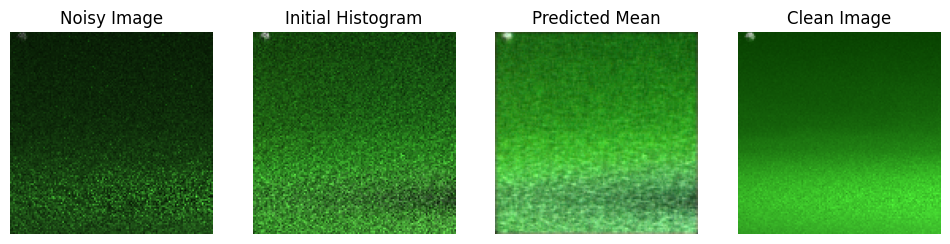

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 4 PSNR (Clean vs Noisy): 50.57 dB
Sample 4 PSNR (Clean vs Init): 23.83 dB
Sample 4 PSNR (Clean vs Predicted): 24.92 dB


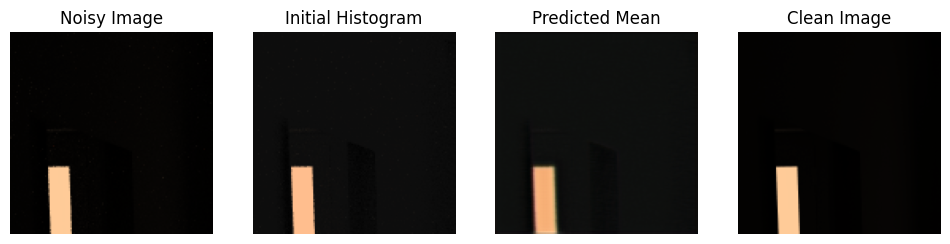

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 5 PSNR (Clean vs Noisy): 50.16 dB
Sample 5 PSNR (Clean vs Init): 22.61 dB
Sample 5 PSNR (Clean vs Predicted): 23.71 dB


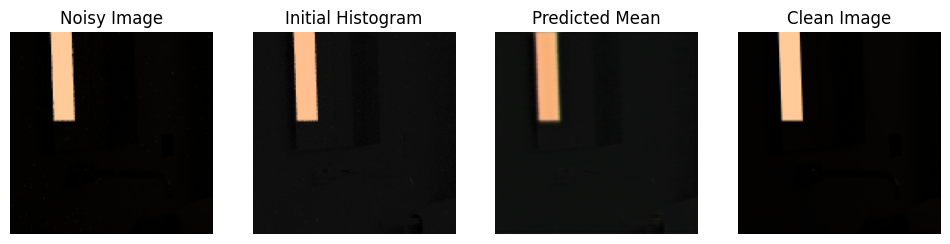

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 6 PSNR (Clean vs Noisy): 56.35 dB
Sample 6 PSNR (Clean vs Init): 51.37 dB
Sample 6 PSNR (Clean vs Predicted): 45.98 dB


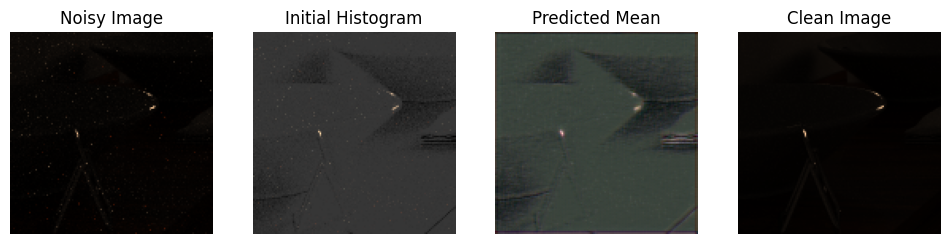

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 7 PSNR (Clean vs Noisy): 59.74 dB
Sample 7 PSNR (Clean vs Init): 51.83 dB
Sample 7 PSNR (Clean vs Predicted): 45.98 dB


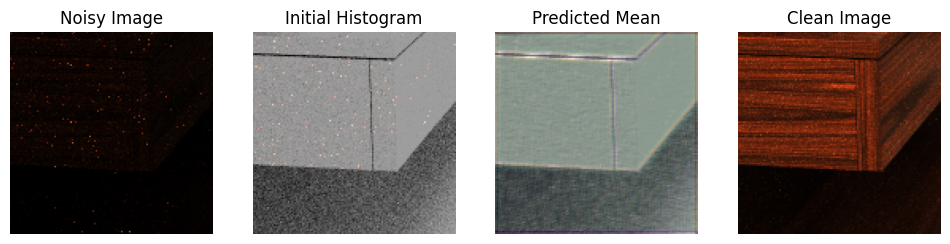

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 8 PSNR (Clean vs Noisy): 65.21 dB
Sample 8 PSNR (Clean vs Init): 51.94 dB
Sample 8 PSNR (Clean vs Predicted): 48.41 dB


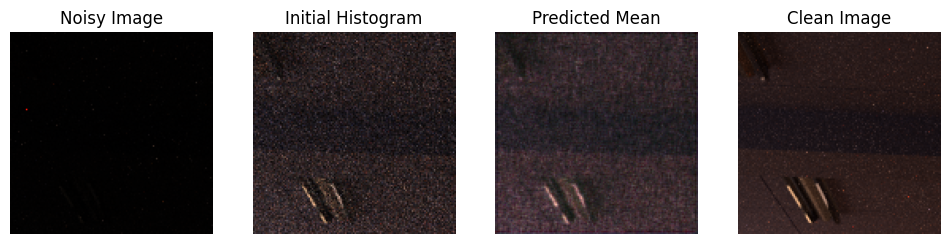

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 9 PSNR (Clean vs Noisy): 63.59 dB
Sample 9 PSNR (Clean vs Init): 40.96 dB
Sample 9 PSNR (Clean vs Predicted): 34.25 dB


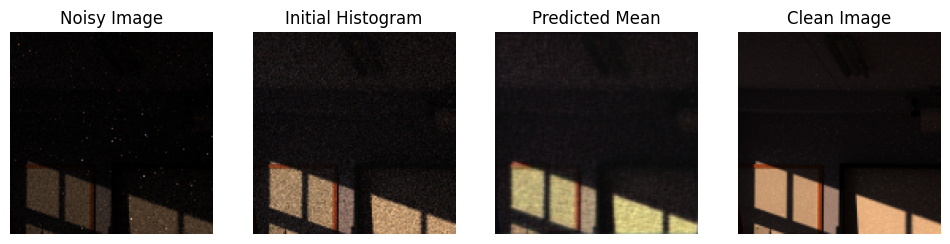

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 10 PSNR (Clean vs Noisy): 58.84 dB
Sample 10 PSNR (Clean vs Init): 38.70 dB
Sample 10 PSNR (Clean vs Predicted): 31.84 dB


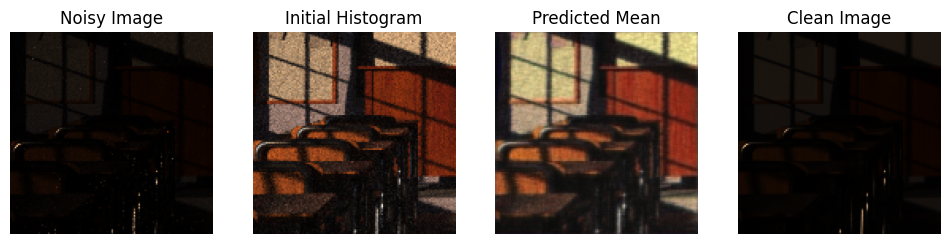

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 11 PSNR (Clean vs Noisy): 59.58 dB
Sample 11 PSNR (Clean vs Init): 48.22 dB
Sample 11 PSNR (Clean vs Predicted): 42.30 dB


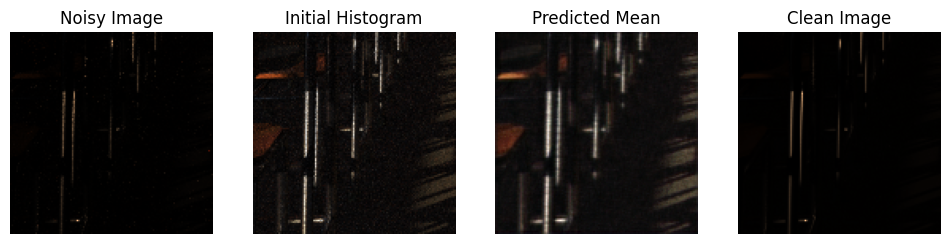

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 12 PSNR (Clean vs Noisy): 84.39 dB
Sample 12 PSNR (Clean vs Init): 41.04 dB
Sample 12 PSNR (Clean vs Predicted): 35.62 dB


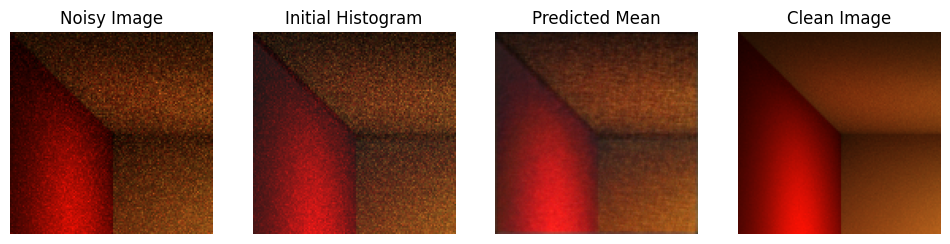

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 13 PSNR (Clean vs Noisy): 86.00 dB
Sample 13 PSNR (Clean vs Init): 37.89 dB
Sample 13 PSNR (Clean vs Predicted): 31.92 dB


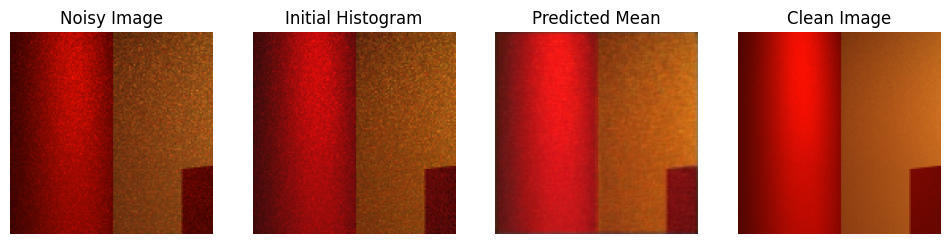

Input Shape:  torch.Size([3, 17, 128, 128])
Pred Mean Shape:  torch.Size([1, 3, 128, 128])
Init Hist Shape:  torch.Size([1, 3, 128, 128])
Sample 14 PSNR (Clean vs Noisy): 88.66 dB
Sample 14 PSNR (Clean vs Init): 41.43 dB
Sample 14 PSNR (Clean vs Predicted): 35.63 dB


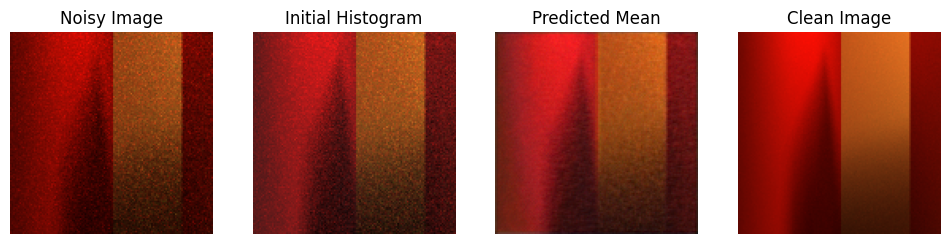

In [83]:
test_and_plot(model, test_loader, device=device, num_samples=20)